## Data Overview

After collecting mass spectrometry data, we want to look for significant features. A few are demonstrated here, giving an overview of the data.


First we import our functions. This file is available on https://github.com/PayneLab/MassSpec-Analysis. 

In [27]:
import nbimporter
%run ms_functions.ipynb

We deal with processed data. The input file is a tab deliminated text file containing the intensities of proteins detected by each reporter. Starting with a raw file, we process it using [MaxQuant](http://www.coxdocs.org/doku.php?id=maxquant:common:download_and_installation). Among the output this produces, under the combined/txt folder, is a file called "proteinGroups.txt" which contains this information. This file is simplified by removing the extra columns and named to identify the experiment.

Using the readin function returns a pandas dataframe of the intensity values from the file.

In [2]:
file = "data/proteinGroups_example_simplified.txt"
msdata = readin(file)

Using the experimental design table, we determine which columns are controls and samples. In the example data there are 10 reporters, including a negative control and a boost column. 

In [3]:
neg_col = 7
boost_col = 9
technical_replicates = {"Cell Line 1":[0,1,2],"Cell Line 2":[3,4,5],"Cell Line 3":[6,8]}

### Evaluating Negative Control

Using a negative control allows us to see what level of intensity represents only bleed over or cross contamination. We can then compare the sample intensities to this threshold.

We use the column numbers defined above to get the intensity values for the negative control.

In [4]:
neg_cont = msdata.iloc[:,neg_col]

We then call the n_thresholds function on the negative control. By default the function will return a 95% threshold, but we can list percents explicitly as well.

In [5]:
thrs = n_thresholds(neg_cont, percents=[50.0,75.0,90.0,95.0,99.0])
thrs = thrs['with_zeros']

50.0% threshold: 0.0
75.0% threshold: 4.2969
90.0% threshold: 190.83
95.0% threshold: 350.74
99.0% threshold: 987.14

Ignoring Zeros: 
50.0% threshold: 148.37
75.0% threshold: 272.9
90.0% threshold: 564.33
95.0% threshold: 847.72
99.0% threshold: 1738.7


Here we see that at the lowest 50% of the negative control data is at 0. In fact, about 74% of the negative control data used in the example is at 0. Then we see that 95% of the data is at or below 350.74 -- much larger than 0, but because intensities are relative, we can only verify whether this is large or small by comparing it to the rest of the data.

We get the sample and boost information.

In [6]:
samples = by_sample(msdata, technical_replicates)
boost = msdata.iloc[:,boost_col]

First we will graph the sample data against the control. Note that the graph is on a log scale and 0 values are not shown, in order to beter view the measuremented data. 

By passing in the 95% threshold calculated above, we get this threshold marked on the graph. The function also prints out the percentage of the sample data above that threshold--in this case, 92.3% of it is. This indicates that most of the sample data represents real measurement rather than noise. By using this threshold as a cutoff point, we loose the lowest sample values and ensure that the values we retain are legitimate measurements.

95.0% of neg cont is at or below solid line.
92.7% of sample data is above the solid line.


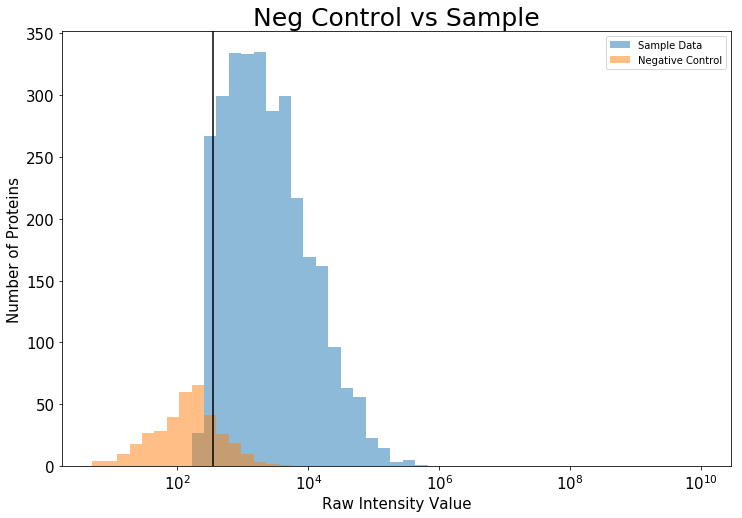

In [28]:
plot_title = "Neg Control vs Sample"
graph_neg_vs_samples(samples, neg_cont, title=plot_title, threshold=thrs[95])

While the above graph does not show 0 values, it may be interesting to view the number of 0 values in the controls and compare that to the samples. By calling the zeros_by_type function, we can see that the majority of the measurements in all but the negative control are non-zero. 

In [31]:
zeros_by_type(samples, neg_cont, boost)

Non-zeros in Neg. Control:	25.77%	(370 of 1436)
Non-zeros in Cell Line 1:	69.43%	(2991 of 4308)
Non-zeros in Cell Line 2:	71.40%	(3076 of 4308)
Non-zeros in Cell Line 3:	72.18%	(2073 of 2872)
Non-zeros in boost:		86.21%	(1238 of 1436)


### Get Fold Change Threshold by Standard Deviations

In [18]:
fold_change_threshold = calc_fold_threshold(msdata, technical_replicates)
print (fold_change_threshold)

1.2253377959588447


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


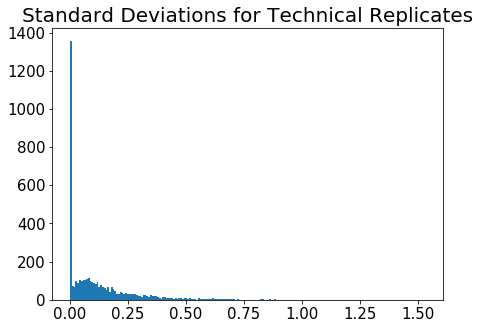

Including Zeros: 
95% threshold:  0.4347730803495055
99% threshold:  0.6780813582540242

Ignoring Zeros: 
95% threshold:  0.5024006729880437
99% threshold:  0.7148694367203182


0.5024006729880437

In [19]:
msdata_log = readin_log(file)
stdevs = get_tech_st_devs(msdata_log, technical_replicates)
plt.rc('axes', titlesize=20)
fig = plt.figure(figsize=(7,5))
plt.hist([x[2] for x in stdevs], bins=200)
plt.title("Standard Deviations for Technical Replicates")
plt.show()
get_thresholds([x[2] for x in stdevs])

### Volcano Plots

In [32]:
neg_data = eval_neg_cont(file, neg_col)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


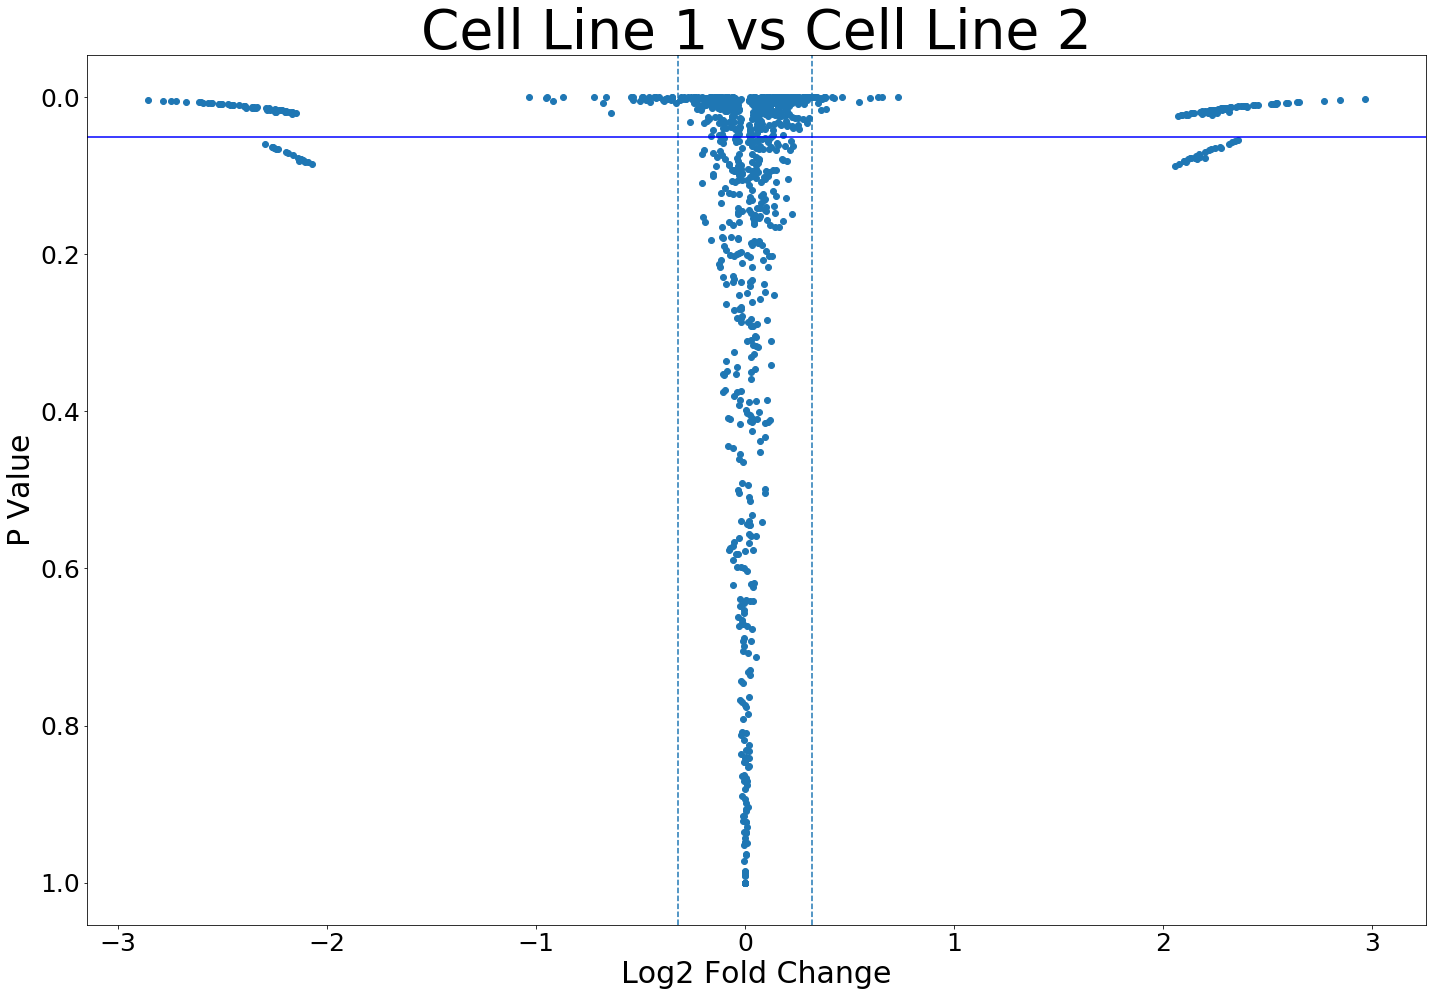

Using a 1.250 fold change threshold
184 proteins change significantly, out of 4308 (4.27%)
97 proteins are upregulated, out of 4308 (2.25%)
87 proteins are downregulated, out of 4308 (2.02%)



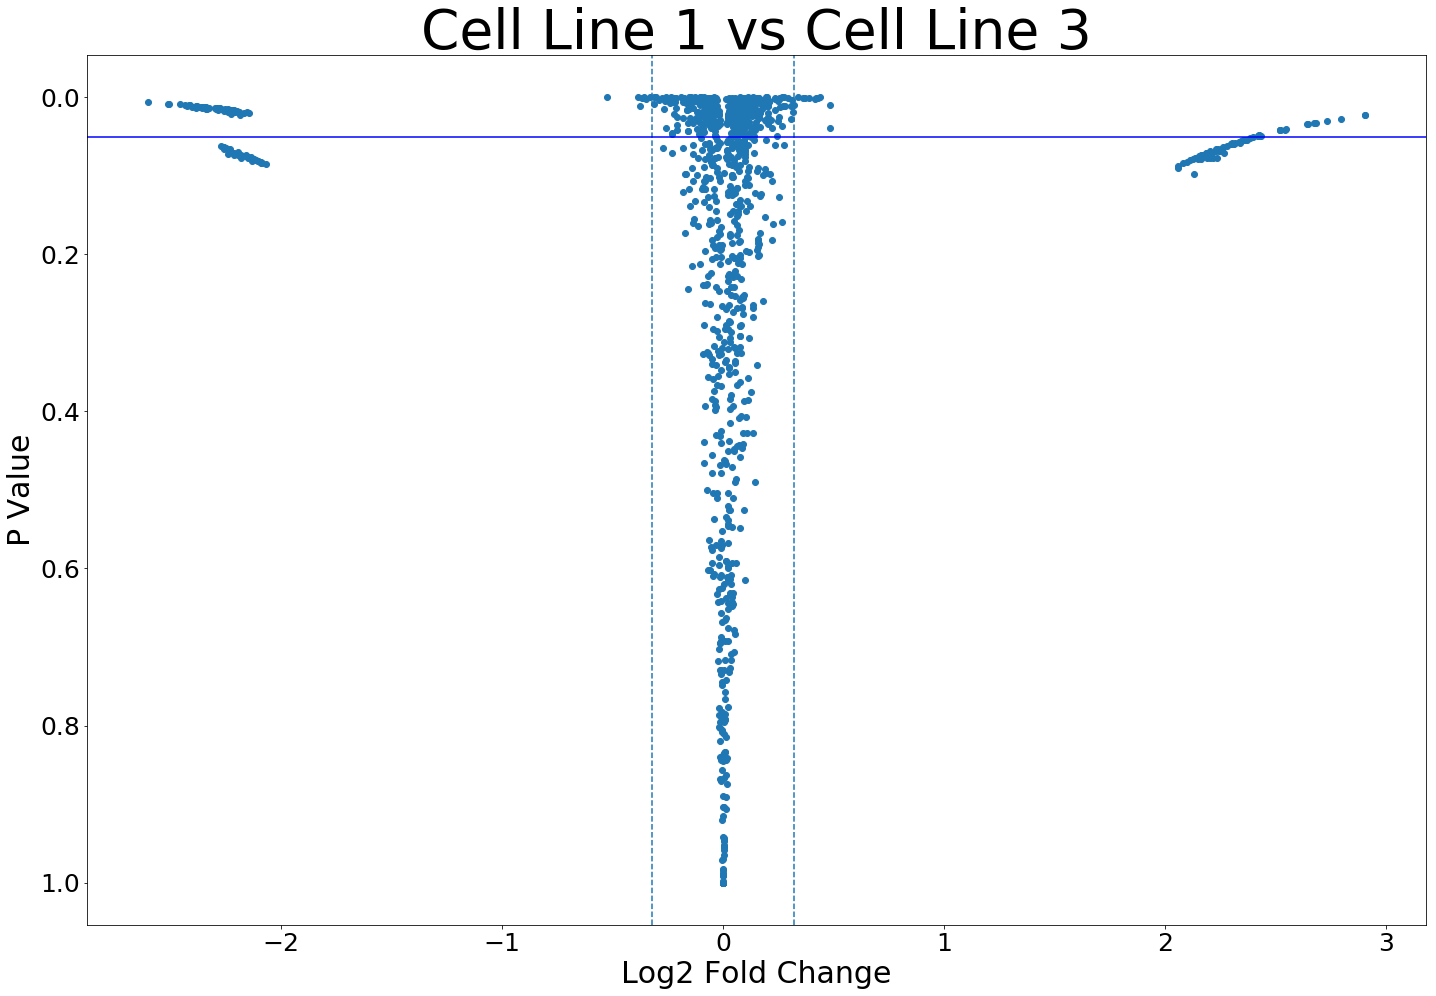

Using a 1.250 fold change threshold
90 proteins change significantly, out of 4308 (2.09%)
30 proteins are upregulated, out of 4308 (0.70%)
60 proteins are downregulated, out of 4308 (1.39%)



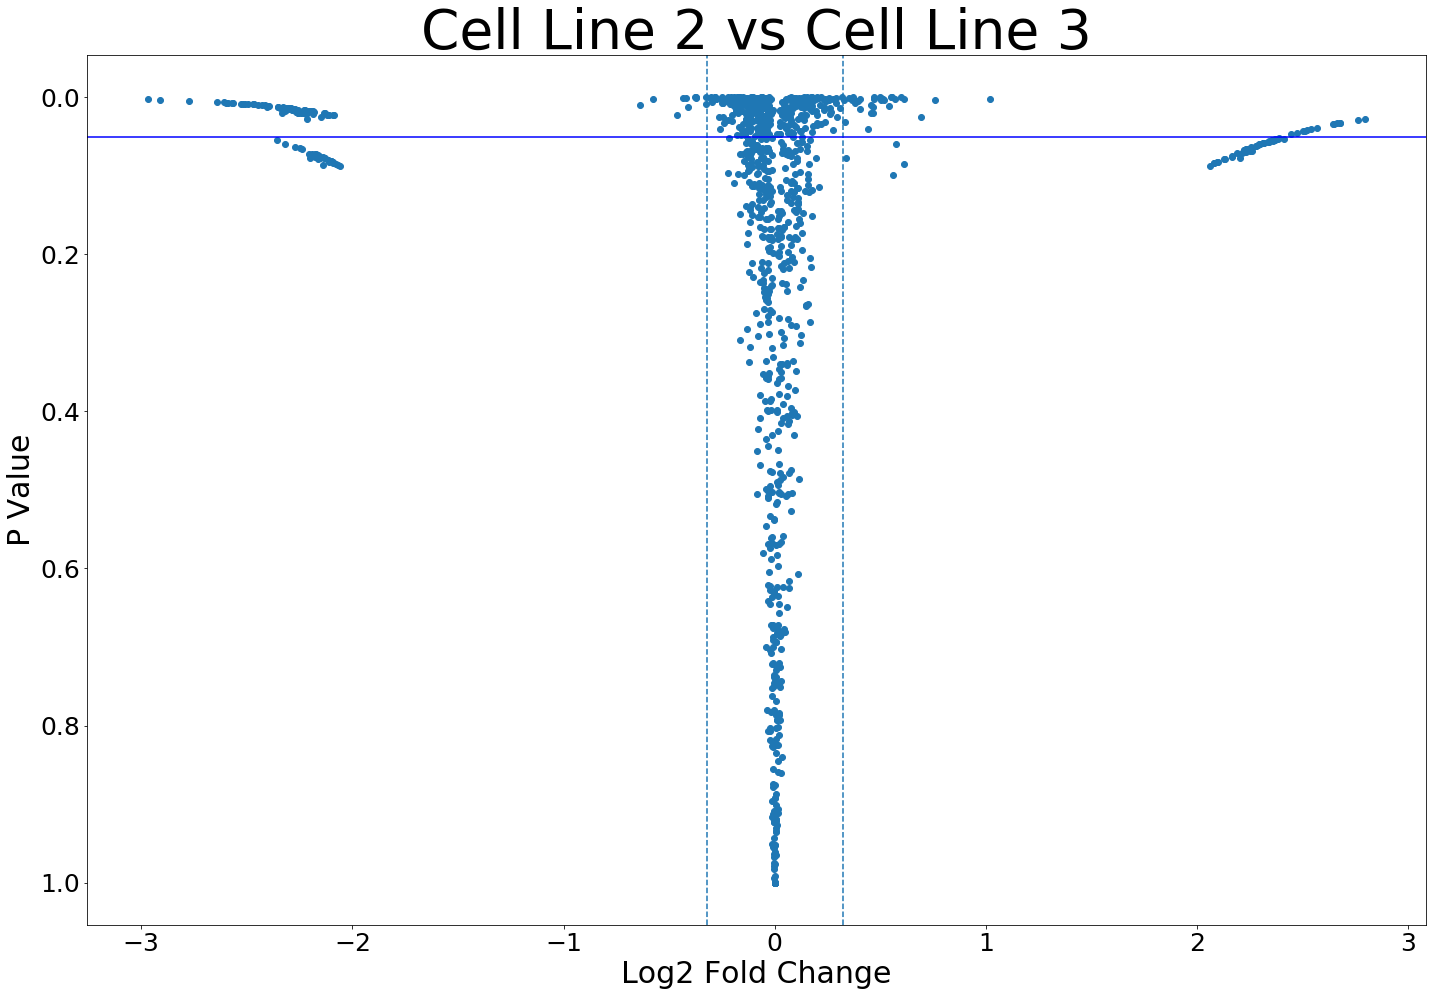

Using a 1.250 fold change threshold
130 proteins change significantly, out of 4308 (3.02%)
45 proteins are upregulated, out of 4308 (1.04%)
85 proteins are downregulated, out of 4308 (1.97%)


In [20]:
samples = by_sample(msdata_log, technical_replicates)
fc_v = get_t_stats(samples,#approxZero = neg_data["ave_zero_log"],
                  #min_threshold=neg_data["log_min_threshold_raw"],
                   report_cat=True)

graph_all_volcanoes(fc_v["fold_changes"], fc_v["t_stats"], 
                    list(technical_replicates.keys()),
                    #fold_change_threshold=fold_change_threshold,
                    fold_change_threshold=1.25,
                    approxZero = neg_data["ave_zero_log"])